In [1]:
"""
Here we do inference on a DICOM volume, constructing the volume first, and then sending it to the
clinical archive

This code will do the following:
    1. Identify the series to run HippoCrop.AI algorithm on from a folder containing multiple studies
    2. Construct a NumPy volume from a set of DICOM files
    3. Run inference on the constructed volume
    4. Create report from the inference
    5. Call a shell script to push report to the storage archive
"""

import os
import sys
import datetime
import time
import shutil
import subprocess

import numpy as np
import pydicom

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from inference.UNetInferenceAgent import UNetInferenceAgent

def load_dicom_volume_as_numpy_from_list(dcmlist):
    """Loads a list of PyDicom objects a Numpy array.
    Assumes that only one series is in the array

    Arguments:
        dcmlist {list of PyDicom objects} -- path to directory

    Returns:
        tuple of (3D volume, header of the 1st image)
    """

    slices = [np.flip(dcm.pixel_array).T for dcm in sorted(dcmlist, key=lambda dcm: dcm.InstanceNumber)]

    hdr = dcmlist[0]

    # zero-out Pixel Data since the users of this function are only interested in metadata
    hdr.PixelData = None
    return (np.stack(slices, 2), hdr)

def get_predicted_volumes(pred):
    """Gets volumes of two hippocampal structures from the predicted array

    Arguments:
        pred {Numpy array} -- array with labels. Assuming 0 is bg, 1 is anterior, 2 is posterior

    Returns:
        A dictionary with respective volumes
    """
    volume_ant = np.sum(pred == 1)
    volume_post = np.sum(pred == 2)
    total_volume = np.sum(pred > 0)
    return {"anterior": volume_ant, "posterior": volume_post, "total": total_volume}

def create_report(inference, header, orig_vol, pred_vol):
    """Generates an image with inference report

    Arguments:
        inference {Dictionary} -- dict containing anterior, posterior and full volume values
        header {PyDicom Dataset} -- DICOM header
        orig_vol {Numpy array} -- original volume
        pred_vol {Numpy array} -- predicted label

    Returns:
        PIL image
    """

    # The code below uses PIL image library to compose an RGB image that will go into the report
    # A standard way of storing measurement data in DICOM archives is creating such report and
    # sending them on as Secondary Capture IODs (http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_A.8.html)
    # Essentially, the report is just a standard RGB image, with some metadata, packed into 
    # DICOM format. 

    pimg = Image.new("RGB", (1000, 1000))
    draw = ImageDraw.Draw(pimg)

    header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
    main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)

#     slice_nums = [orig_vol.shape[2]//3, orig_vol.shape[2]//2, orig_vol.shape[2]*3//4] 

    # Create the report and show information relevant to clinicians. 

    draw.text((50, 50), "HippoVolume.AI", (255, 255, 255), font=header_font)
    draw.multiline_text((50, 140),
                        f"Patient ID: {header.PatientID} \n \
                        Study Description : {header.StudyDescription}\n \
                        Series Description: {header.SeriesDescription}\n \
                        Modality: {header.Modality}\n \
                        Image Type: {header.ImageType}\n \
                        Anterior Volume: {inference['anterior']}\n \
                        Posterior Volume: {inference['posterior']}\n \
                        Total Volume: {inference['total']}\n",                                     
                        (255, 255, 255), font=main_font)

    # Create a PIL image from array:
    # Numpy array needs to flipped, transposed and normalized to a matrix of values in the range of [0..255]
    nd_orig = np.flip((orig_vol[0, :, :]/np.max(orig_vol[0, :, :]))*0xff).T.astype(np.uint8)
    # create a PIL image from numpy array
    pil_orig = Image.fromarray(nd_orig, mode="L").convert("RGBA").resize((400, 400))
    # paste the PIL image into the main report image object (pimg)
    pimg.paste(pil_orig, box=(50, 500))
    
    nd_pred = np.flip((pred_vol[0, :, :]/np.max(pred_vol[0, :, :]))*0xff).T.astype(np.uint8)
    # create a PIL image from numpy array
    pil_pred = Image.fromarray(nd_pred, mode="L").convert("RGBA").resize((400, 400))
    # paste the PIL image into the main report image object (pimg)
    pimg.paste(pil_pred, box=(550, 500))

    return pimg

def save_report_as_dcm(header, report, path):
    """Writes the supplied image as a DICOM Secondary Capture file

    Arguments:
        header {PyDicom Dataset} -- original DICOM file header
        report {PIL image} -- image representing the report
        path {Where to save the report}

    Returns:
        N/A
    """

    # create a DICOM Secondary Capture instance that will be correctly interpreted by most imaging viewers including OHIF
    # Set up DICOM metadata fields. Most of them will be the same as original file header
    out = pydicom.Dataset(header)

    out.file_meta = pydicom.Dataset()
    out.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    out.is_little_endian = True
    out.is_implicit_VR = False

    # change class to Secondary Capture
    out.SOPClassUID = "1.2.840.10008.5.1.4.1.1.7"
    out.file_meta.MediaStorageSOPClassUID = out.SOPClassUID

    # The report is a separate image series of one image
    out.SeriesInstanceUID = pydicom.uid.generate_uid()
    out.SOPInstanceUID = pydicom.uid.generate_uid()
    out.file_meta.MediaStorageSOPInstanceUID = out.SOPInstanceUID
    out.Modality = "OT" 
    out.SeriesDescription = "HippoVolume.AI"

    out.Rows = report.height
    out.Columns = report.width

    out.ImageType = r"DERIVED\PRIMARY\AXIAL" # deriving this image from patient data
    out.SamplesPerPixel = 3 # building an RGB image.
    out.PhotometricInterpretation = "RGB"
    out.PlanarConfiguration = 0 # bytes encode pixels as R1G1B1R2G2B2... as opposed to R1R2R3...G1G2G3...
    out.BitsAllocated = 8 # using 8 bits/pixel
    out.BitsStored = 8
    out.HighBit = 7
    out.PixelRepresentation = 0

    # Set time and date
    dt = datetime.date.today().strftime("%Y%m%d")
    tm = datetime.datetime.now().strftime("%H%M%S")
    out.StudyDate = dt
    out.StudyTime = tm
    out.SeriesDate = dt
    out.SeriesTime = tm

    out.ImagesInAcquisition = 1

    # empty these since most viewers will then default to auto W/L
    out.WindowCenter = ""
    out.WindowWidth = ""

    # Data imprinted directly into image pixels is called "burned in annotation"
    out.BurnedInAnnotation = "YES"

    out.PixelData = report.tobytes()

    pydicom.filewriter.dcmwrite(path, out, write_like_original=False)
    
# path = '../TestVolumes'
def get_series_for_inference(path):
    """Reads multiple series from one folder and picks the one
    to run inference on.

    Arguments:
        path {string} -- location of the DICOM files

    Returns:
        Numpy array representing the series
    """

    series_path = [dir for dir, subdirs, files in os.walk(path) if 'HCropVolume' in dir]
    chosen_path = np.random.choice(series_path)  
    series_for_inference = [pydicom.dcmread(os.path.join(chosen_path, f)) for f in os.listdir(chosen_path)]

    # Check if there are more than one series (using set comprehension).
    if len({f.SeriesInstanceUID for f in series_for_inference}) != 1:
        print("Error: can not figure out what series to run inference on")
        return []

    return series_for_inference

def os_command(command):
    # Comment this if running under Windows
    sp = subprocess.Popen(["/bin/bash", "-i", "-c", command])
    sp.communicate()

    # Uncomment this if running under Windows
    # os.system(command)

if __name__ == "__main__":
    # This code expects a single command line argument with link to the directory containing
    # routed studies
    if len(sys.argv) != 2:
        print("You should supply one command line argument pointing to the routing folder. Exiting.")
        sys.exit()

    # Find all subdirectories within the supplied directory. We assume that 
    # one subdirectory contains a full study
    subdirs = [os.path.join(sys.argv[1], d) for d in os.listdir(sys.argv[1]) if
                os.path.isdir(os.path.join(sys.argv[1], d))]

    # Get the latest directory
    study_dir = sorted(subdirs, key=lambda dir: os.stat(dir).st_mtime, reverse=True)[0]

    print(f"Looking for series to run inference on in directory {study_dir}...")

    volume, header = load_dicom_volume_as_numpy_from_list(get_series_for_inference(study_dir))
    print(f"Found series of {volume.shape[2]} axial slices")

    print("HippoVolume.AI: Running inference...")
    # Use the UNetInferenceAgent class and model parameter file from the previous section
    inference_agent = UNetInferenceAgent(
        device="cpu",
        parameter_file_path=r"")

    # Run inference
    pred_label = inference_agent.single_volume_inference_unpadded(np.array(volume))
    pred_volumes = get_predicted_volumes(pred_label)

    # Create and save the report
    print("Creating and pushing report...")
    report_save_path = r"../out/report.dcm"
    report_img = create_report(pred_volumes, header, volume, pred_label)
    save_report_as_dcm(header, report_img, report_save_path)

    # Send report to the storage archive
    os_command("sudo storescu localhost 4242 -v -aec HIPPOAI +r +sd ../out/report.dcm")

    # remove the study dir if run as root user
    # sleep to let the StoreSCP server process the report 
    # the main archive is routing everyting that is sent to it, including thefreshly generated report
    # I want to give it time to save before cleaning it up
    time.sleep(2)
    shutil.rmtree(study_dir, onerror=lambda f, p, e: print(f"Error deleting: {e[1]}"))

    print(f"Inference successful on {header['SOPInstanceUID'].value}, out: {pred_label.shape}",
          f"volume ant: {pred_volumes['anterior']}, ",
          f"volume post: {pred_volumes['posterior']}, total volume: {pred_volumes['total']}")

You should supply one command line argument pointing to the routing folder. Exiting.


SystemExit: 

/root/miniconda3/envs/medai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
path = '../TestVolumes'
dcmlist = get_series_for_inference(path)
volume, header = load_dicom_volume_as_numpy_from_list(dcmlist)

In [3]:
volume.shape

(36, 48, 35)

In [4]:
header

(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.26185900803004219333295727139294635608
(0008, 0020) Study Date                          DA: '20200121'
(0008, 0021) Series Date                         DA: '20200121'
(0008, 0022) Acquisition Date                    DA: '20200121'
(0008, 0023) Content Date                        DA: '20200121'
(0008, 0030) Study Time                          TM: '010643'
(0008, 0031) Series Time                         TM: '010643'
(0008, 0050) Accession Number                    SH: '5422251365919463'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'MR RCBV SEQUENCE'
(0008, 103e) Series Description

In [5]:
inference_agent = UNetInferenceAgent(device="cpu",parameter_file_path=r"")

In [6]:
pred_label = inference_agent.single_volume_inference_unpadded(np.array(volume), 64)
pred_volumes = get_predicted_volumes(pred_label)

Creating and pushing report...


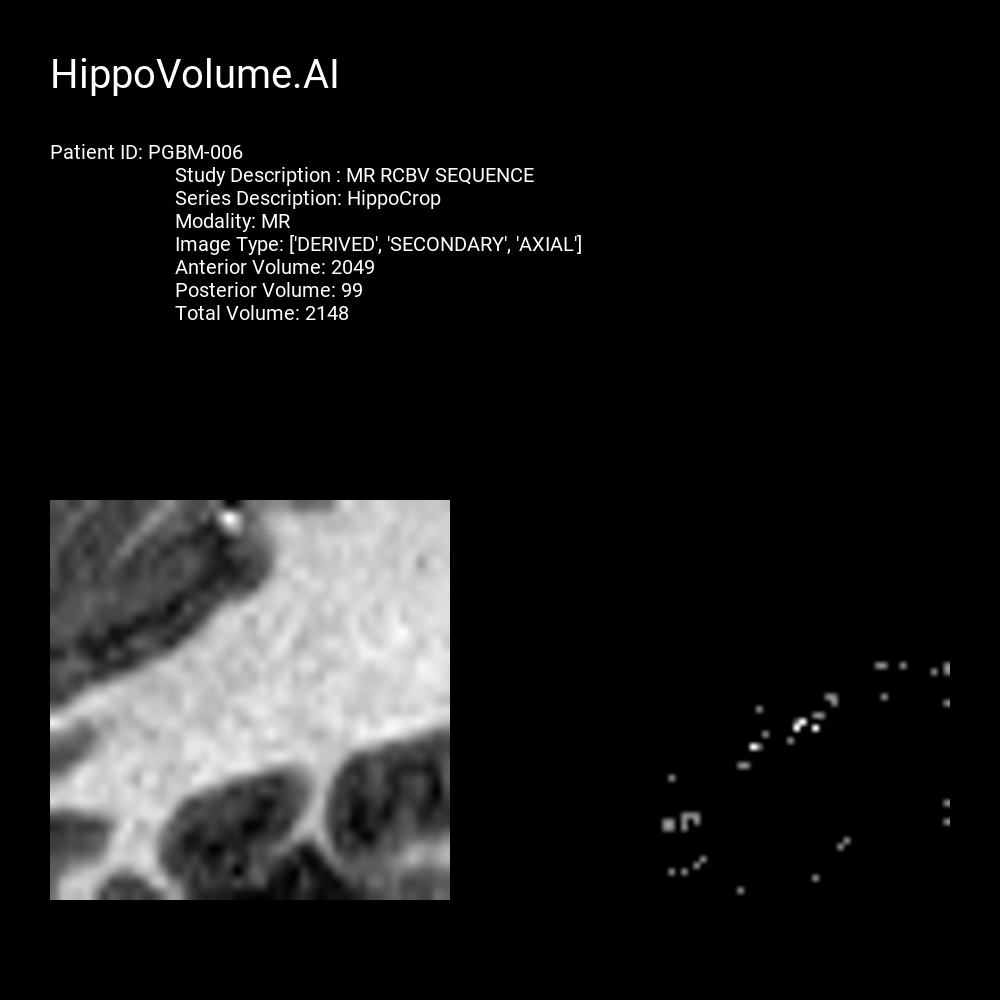

In [7]:
# Create and save the report
print("Creating and pushing report...")
report_img = create_report(pred_volumes, header, volume, pred_label)
report_img

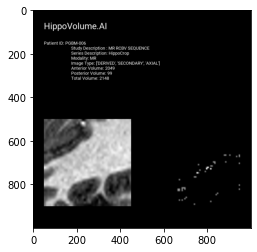

In [9]:
from matplotlib.pyplot import imshow
%matplotlib inline
report_save_path = r"../out/report.dcm"
save_report_as_dcm(header, report_img, report_save_path)
imshow(np.asarray(pydicom.dcmread(report_save_path).pixel_array))